In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
import scipy.stats as stats
import math
import statistics

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
livetime = 8 * u.h
n_obs = 125
l = 0.1
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 40), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 200), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [7]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s



In [9]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 3498 
    Total predicted counts          : nan
    Total background counts         : 3534.26

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [11]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 6051 
    Total predicted counts          : 6074.80
    Total off counts                : 17626.00

    Total background counts         : 3525.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 26.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [12]:
%%time

datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 816 ms, sys: 3.55 ms, total: 820 ms
Wall time: 831 ms


Text(0, 0.5, 'No. of observations')

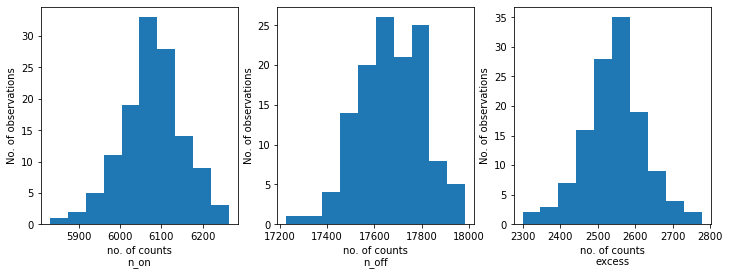

In [13]:
n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:
%%time
results = []
fpes = []
e_edges = np.logspace(-1.5, 2.0, 10) * u.TeV
model_best_joints = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.run()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "reference":result.parameters["reference"].value,
            "lambda_": result.parameters["lambda_"].value,
            "alpha":result.parameters["alpha"].value,
        }
    )
    print(result.parameters.to_table())
    fpe = FluxPointsEstimator(datasets=[dataset], e_edges=e_edges)
    flux_points = fpe.run()
    print(flux_points.table_formatted)
    fpes.append(flux_points)
    model_best_joint = model.copy()
    model_best_joint.spectral_model.parameters.covariance = (result.parameters.covariance)
    model_best_joints.append(model_best_joint)

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.274e+00 2.969e-02                nan nan  False
amplitude 1.250e-12 6.699e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 9.679e-02 2.142e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.117e-10       1.117e-10       1.117e-10
 0.121  0.072   0.203 ...       7.458e-12       7.480e-12       7.436e-12
 0.307  0.203   0.464 ...       9.799e-13       9.909e-13       9.690e-13
 0.702  0.464   1.061 ...       1.760e-13       1.787e-13       1.733e-13
 1.778  1.061   2.981 ...       1.956e-14       1.996e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.083e-10       1.090e-10       1.077e-10
 0.121  0.072   0.203 ...       7.438e-12       7.493e-12       7.383e-12
 0.307  0.203   0.464 ...       9.680e-13       9.720e-13       9.638e-13
 0.702  0.464   1.061 ...       1.726e-13       1.755e-13       1.698e-13
 1.778  1.061   2.981 ...       2.016e-14       2.056e-14       1.977e-14
 4.507  2.981   6.813 ...       2.878e-15       2.976e-15       2.783e-15
10.300  6.813  15.571 ...       5.370e-16       5.724e-16       5.030e-16
26.102 15.571  43.755 ...       2.616e-17       3.120e-17       2.178e-17
66.147 43.755 100.000 ...       4.185e-22       1.016e-18       4.310e-26
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.155e+00 3.235e-02                nan nan  False
amplitude 1.412e-12 7.885e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 1.447e-01 2.429e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.067e-10       1.073e-10       1.061e-10
 0.121  0.072   0.203 ...       7.261e-12       7.272e-12       7.250e-12
 0.307  0.203   0.464 ...       1.004e-12       1.010e-12       9.988e-13
 0.702  0.464   1.061 ...       1.717e-13       1.746e-13       1.689e-13
 1.778  1.061   2.981 ...       2.039e-14       2.080e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.113e-10       1.119e-10       1.106e-10
 0.121  0.072   0.203 ...       7.255e-12       7.301e-12       7.209e-12
 0.307  0.203   0.464 ...       9.934e-13       9.985e-13       9.882e-13
 0.702  0.464   1.061 ...       1.625e-13       1.653e-13       1.598e-13
 1.778  1.061   2.981 ...       1.956e-14       1.995e-14       1.917e-14
 4.507  2.981   6.813 ...       3.127e-15       3.222e-15       3.033e-15
10.300  6.813  15.571 ...       5.655e-16       6.026e-16       5.298e-16
26.102 15.571  43.755 ...       4.143e-17       4.786e-17       3.624e-17
66.147 43.755 100.000 ...       3.398e-21       2.778e-18       1.039e-24
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.186e+00 3.223e-02                nan nan  False
amplitude 1.374e-12 7.760e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 1.359e-01 2.459e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.085e-10       1.086e-10       1.083e-10
 0.121  0.072   0.203 ...       7.300e-12       7.312e-12       7.287e-12
 0.307  0.203   0.464 ...       9.889e-13       9.968e-13       9.811e-13
 0.702  0.464   1.061 ...       1.732e-13       1.760e-13       1.704e-13
 1.778  1.061   2.981 ...       2.088e-14       2.143e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.097e-10       1.098e-10       1.097e-10
 0.121  0.072   0.203 ...       7.281e-12       7.328e-12       7.233e-12
 0.307  0.203   0.464 ...       1.003e-12       1.011e-12       9.942e-13
 0.702  0.464   1.061 ...       1.649e-13       1.679e-13       1.620e-13
 1.778  1.061   2.981 ...       1.974e-14       2.014e-14       1.935e-14
 4.507  2.981   6.813 ...       2.869e-15       2.971e-15       2.769e-15
10.300  6.813  15.571 ...       4.829e-16       5.183e-16       4.493e-16
26.102 15.571  43.755 ...       2.301e-19       1.868e-17       2.880e-22
66.147 43.755 100.000 ...       4.098e-22       1.029e-18       4.077e-26
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.085e-10       1.091e-10       1.078e-10
 0.121  0.072   0.203 ...       7.414e-12       7.464e-12       7.363e-12
 0.307  0.203   0.464 ...       9.854e-13       9.950e-13       9.759e-13
 0.702  0.464   1.061 ...       1.663e-13       1.691e-13       1.635e-13
 1.778  1.061   2.981 ...       1.925e-14       1.967e-14       1.883e-14
 4.507  2.981   6.813 ...       2.917e-15       3.012e-15       2.825e-15
10.300  6.813  15.571 ...       5.598e-16       6.009e-16       5.210e-16
26.102 15.571  43.755 ...       3.604e-17       4.411e-17       2.801e-17
66.147 43.755 100.000 ...       2.290e-21       2.355e-18       5.560e-25
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.259e+00 3.082e-02                nan nan  False
amplitude 1.120e-12 6.042e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 8.449e-02 1.993e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.091e-10       1.098e-10       1.085e-10
 0.121  0.072   0.203 ...       7.324e-12       7.377e-12       7.271e-12
 0.307  0.203   0.464 ...       9.510e-13       9.583e-13       9.436e-13
 0.702  0.464   1.061 ...       1.622e-13       1.650e-13       1.595e-13
 1.778  1.061   2.981 ...       1.866e-14       1.909e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.094e-10       1.100e-10       1.088e-10
 0.121  0.072   0.203 ...       7.472e-12       7.526e-12       7.418e-12
 0.307  0.203   0.464 ...       9.884e-13       9.977e-13       9.792e-13
 0.702  0.464   1.061 ...       1.662e-13       1.689e-13       1.634e-13
 1.778  1.061   2.981 ...       1.978e-14       2.019e-14       1.938e-14
 4.507  2.981   6.813 ...       3.048e-15       3.149e-15       2.950e-15
10.300  6.813  15.571 ...       6.025e-16       6.402e-16       5.662e-16
26.102 15.571  43.755 ...       6.299e-17       7.069e-17       6.023e-17
66.147 43.755 100.000 ...       8.438e-21       4.040e-18       4.405e-24
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.082e-10       1.083e-10       1.081e-10
 0.121  0.072   0.203 ...       7.237e-12       7.242e-12       7.232e-12
 0.307  0.203   0.464 ...       9.864e-13       9.971e-13       9.758e-13
 0.702  0.464   1.061 ...       1.783e-13       1.813e-13       1.754e-13
 1.778  1.061   2.981 ...       2.043e-14       2.084e-14       2.002e-14
 4.507  2.981   6.813 ...       3.066e-15       3.172e-15       2.964e-15
10.300  6.813  15.571 ...       5.815e-16       6.172e-16       5.471e-16
26.102 15.571  43.755 ...       3.896e-17       4.498e-17       3.625e-17
66.147 43.755 100.000 ...       1.293e-21       1.686e-18       2.475e-25
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.226e+00 2.993e-02                nan nan  False
amplitude 1.240e-12 6.356e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 8.822e-02 1.928e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.098e-10       1.103e-10       1.092e-10
 0.121  0.072   0.203 ...       7.344e-12       7.396e-12       7.293e-12
 0.307  0.203   0.464 ...       9.656e-13       9.729e-13       9.582e-13
 0.702  0.464   1.061 ...       1.632e-13       1.659e-13       1.605e-13
 1.778  1.061   2.981 ...       2.061e-14       2.101e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.116e-10       1.123e-10       1.110e-10
 0.121  0.072   0.203 ...       7.306e-12       7.351e-12       7.261e-12
 0.307  0.203   0.464 ...       9.974e-13       1.006e-12       9.887e-13
 0.702  0.464   1.061 ...       1.717e-13       1.745e-13       1.689e-13
 1.778  1.061   2.981 ...       1.974e-14       2.016e-14       1.932e-14
 4.507  2.981   6.813 ...       2.971e-15       3.075e-15       2.870e-15
10.300  6.813  15.571 ...       5.084e-16       5.437e-16       4.744e-16
26.102 15.571  43.755 ...       3.183e-17       3.737e-17       2.686e-17
66.147 43.755 100.000 ...       6.158e-22       1.225e-18       7.704e-26
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.094e-10       1.100e-10       1.088e-10
 0.121  0.072   0.203 ...       7.350e-12       7.400e-12       7.299e-12
 0.307  0.203   0.464 ...       9.696e-13       9.806e-13       9.587e-13
 0.702  0.464   1.061 ...       1.800e-13       1.828e-13       1.773e-13
 1.778  1.061   2.981 ...       1.995e-14       2.042e-14       1.948e-14
 4.507  2.981   6.813 ...       3.129e-15       3.232e-15       3.029e-15
10.300  6.813  15.571 ...       5.747e-16       6.116e-16       5.392e-16
26.102 15.571  43.755 ...       3.854e-17       4.517e-17       3.246e-17
66.147 43.755 100.000 ...       2.593e-21       2.406e-18       6.977e-25
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.165e+00 3.100e-02                nan nan  False
amplitude 1.430e-12 7.628e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 1.310e-01 2.239e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.065e-10       1.062e-10       1.068e-10
 0.121  0.072   0.203 ...       7.296e-12       7.348e-12       7.246e-12
 0.307  0.203   0.464 ...       9.984e-13       1.010e-12       9.873e-13
 0.702  0.464   1.061 ...       1.689e-13       1.722e-13       1.658e-13
 1.778  1.061   2.981 ...       2.132e-14       2.182e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.106e-10       1.112e-10       1.100e-10
 0.121  0.072   0.203 ...       7.363e-12       7.356e-12       7.369e-12
 0.307  0.203   0.464 ...       9.816e-13       9.900e-13       9.731e-13
 0.702  0.464   1.061 ...       1.717e-13       1.745e-13       1.690e-13
 1.778  1.061   2.981 ...       1.952e-14       1.996e-14       1.910e-14
 4.507  2.981   6.813 ...       3.137e-15       3.233e-15       3.044e-15
10.300  6.813  15.571 ...       5.759e-16       6.118e-16       5.413e-16
26.102 15.571  43.755 ...       4.123e-17       4.901e-17       3.450e-17
66.147 43.755 100.000 ...       2.770e-21       2.534e-18       7.564e-25
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.102e-10       1.108e-10       1.096e-10
 0.121  0.072   0.203 ...       7.311e-12       7.324e-12       7.297e-12
 0.307  0.203   0.464 ...       1.002e-12       1.014e-12       9.912e-13
 0.702  0.464   1.061 ...       1.694e-13       1.722e-13       1.666e-13
 1.778  1.061   2.981 ...       1.989e-14       2.031e-14       1.947e-14
 4.507  2.981   6.813 ...       2.937e-15       3.031e-15       2.844e-15
10.300  6.813  15.571 ...       5.482e-16       5.838e-16       5.138e-16
26.102 15.571  43.755 ...       3.529e-17       4.126e-17       2.990e-17
66.147 43.755 100.000 ...       1.262e-21       1.746e-18       2.275e-25
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.228e+00 3.193e-02                nan nan  False
amplitude 1.221e-12 6.806e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 7.919e-02 2.174e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.094e-10       1.101e-10       1.088e-10
 0.121  0.072   0.203 ...       7.191e-12       7.223e-12       7.158e-12
 0.307  0.203   0.464 ...       9.740e-13       9.843e-13       9.637e-13
 0.702  0.464   1.061 ...       1.709e-13       1.737e-13       1.681e-13
 1.778  1.061   2.981 ...       2.038e-14       2.092e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.100e-10       1.108e-10       1.092e-10
 0.121  0.072   0.203 ...       7.232e-12       7.259e-12       7.204e-12
 0.307  0.203   0.464 ...       9.916e-13       1.003e-12       9.808e-13
 0.702  0.464   1.061 ...       1.666e-13       1.695e-13       1.637e-13
 1.778  1.061   2.981 ...       1.993e-14       2.033e-14       1.954e-14
 4.507  2.981   6.813 ...       3.039e-15       3.137e-15       2.944e-15
10.300  6.813  15.571 ...       4.009e-16       4.344e-16       3.693e-16
26.102 15.571  43.755 ...       3.363e-20       1.757e-17       4.623e-24
66.147 43.755 100.000 ...       1.216e-22       5.359e-19       6.902e-27
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.088e-10       1.089e-10       1.086e-10
 0.121  0.072   0.203 ...       7.276e-12       7.320e-12       7.232e-12
 0.307  0.203   0.464 ...       9.995e-13       1.010e-12       9.888e-13
 0.702  0.464   1.061 ...       1.730e-13       1.758e-13       1.703e-13
 1.778  1.061   2.981 ...       1.951e-14       1.998e-14       1.904e-14
 4.507  2.981   6.813 ...       3.026e-15       3.121e-15       2.934e-15
10.300  6.813  15.571 ...       4.494e-16       4.842e-16       4.162e-16
26.102 15.571  43.755 ...       2.749e-17       3.278e-17       2.606e-17
66.147 43.755 100.000 ...       5.681e-22       1.194e-18       6.757e-26
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

index: 2.2153521560633895 += 0.03405910972129102


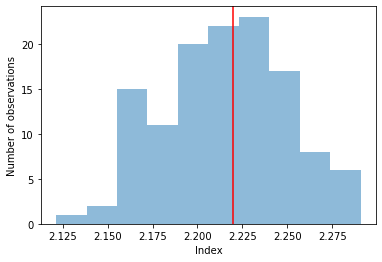

In [15]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel('Index')
plt.ylabel('Number of observations')
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.299052832848987e-12 += 7.995573918202133e-14


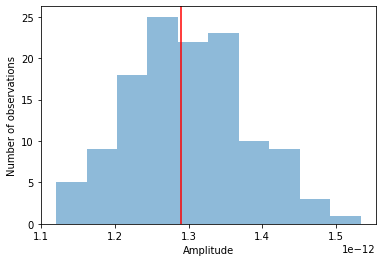

In [16]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel('Amplitude')
plt.ylabel('Number of observations')
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

In [17]:
reference = np.array([_["reference"] for _ in results])
lambda_ = np.array([_["lambda_"] for _ in results])
alpha = np.array([_["alpha"] for _ in results])
x = np.array([index, amplitude, reference, lambda_, alpha])
covar=np.cov(x)
print(covar)

[[ 1.16937798e-03 -2.38056620e-15  0.00000000e+00 -6.34888506e-04
   0.00000000e+00]
 [-2.38056620e-15  6.44447604e-27  0.00000000e+00  1.56740622e-15
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.34888506e-04  1.56740622e-15  0.00000000e+00  5.59140147e-04
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


In [18]:
simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [19]:
i = 0
fpes[i].table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.253e-09,5.184e-11,2.372e-12,2.863e-12,0.970,5.818,0.089,2670,0.089,0.089,1.150,11.619,135.000,0.200 .. 5.000,88.470 .. 1351.475,1.215e-09,1.440e-09,1.117e-10,1.117e-10,1.117e-10
0.121,0.072,0.203,1.501e-10,2.019e-11,2.284e-12,2.204e-12,1.023,12.666,0.050,2045,0.050,0.050,1.123,24.019,576.892,0.200 .. 5.000,362.220 .. 3195.764,1.536e-10,1.686e-10,7.458e-12,7.480e-12,7.436e-12
0.307,0.203,0.464,1.779e-11,4.733e-12,1.389e-12,1.677e-12,0.925,0.824,0.055,704,0.056,0.054,1.038,21.147,447.215,0.200 .. 5.000,246.906 .. 2117.341,1.646e-11,1.847e-11,9.799e-13,9.909e-13,9.690e-13
0.702,0.464,1.061,2.614e-12,1.592e-12,1.065e-12,1.287e-12,1.055,2.472,0.067,394,0.068,0.066,1.193,21.968,482.577,0.200 .. 5.000,275.372 .. 1268.266,2.757e-12,3.120e-12,1.760e-13,1.787e-13,1.733e-13
1.778,1.061,2.981,2.843e-13,5.678e-13,9.299e-13,8.989e-13,1.010,2.560,0.069,261,0.070,0.067,1.153,23.055,531.542,0.200 .. 5.000,276.789 .. 1090.054,2.870e-13,3.277e-13,1.956e-14,1.996e-14,1.917e-14
4.507,2.981,6.813,2.634e-14,1.052e-13,4.431e-13,5.350e-13,1.057,2.445,0.111,106,0.115,0.107,1.294,15.216,231.520,0.200 .. 5.000,124.105 .. 419.283,2.783e-14,3.408e-14,2.930e-15,3.037e-15,2.826e-15
10.300,6.813,15.571,2.295e-15,2.189e-14,2.048e-13,2.435e-13,0.923,2.169,0.226,23,0.242,0.211,1.437,6.272,39.342,0.200 .. 5.000,20.867 .. 105.044,2.119e-15,3.299e-15,5.178e-16,5.543e-16,4.831e-16
26.102,15.571,43.755,6.001e-17,2.519e-15,5.193e-14,4.088e-14,1.096,3.856,0.600,4,0.703,0.508,2.718,2.519,6.344,0.200 .. 5.000,7.840 .. 18.428,6.576e-17,1.631e-16,3.603e-17,4.220e-17,3.050e-17


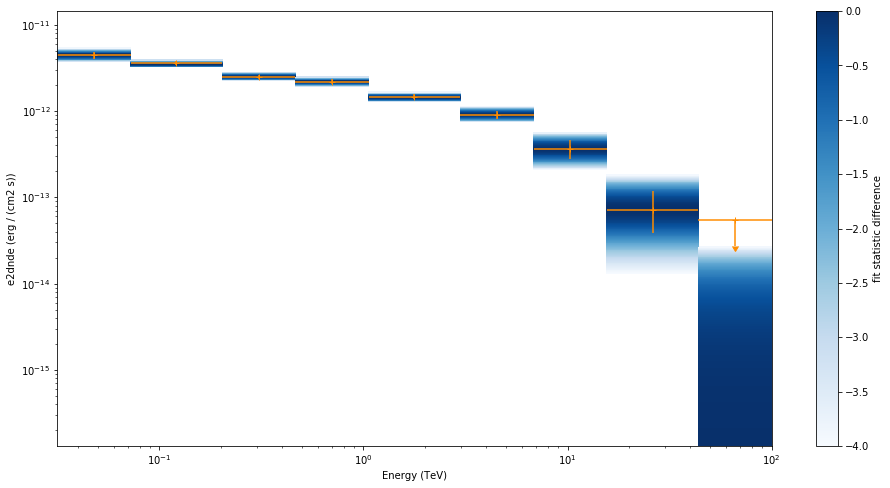

In [20]:
plt.figure(figsize=(16, 8))
fpes[i].table["is_ul"] = fpes[i].table["ts"] < 4
ax = fpes[i].plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
fpes[i].to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [21]:
flux_points_dataset = FluxPointsDataset(
    data=fpes[i], models=model_best_joints[i]
)

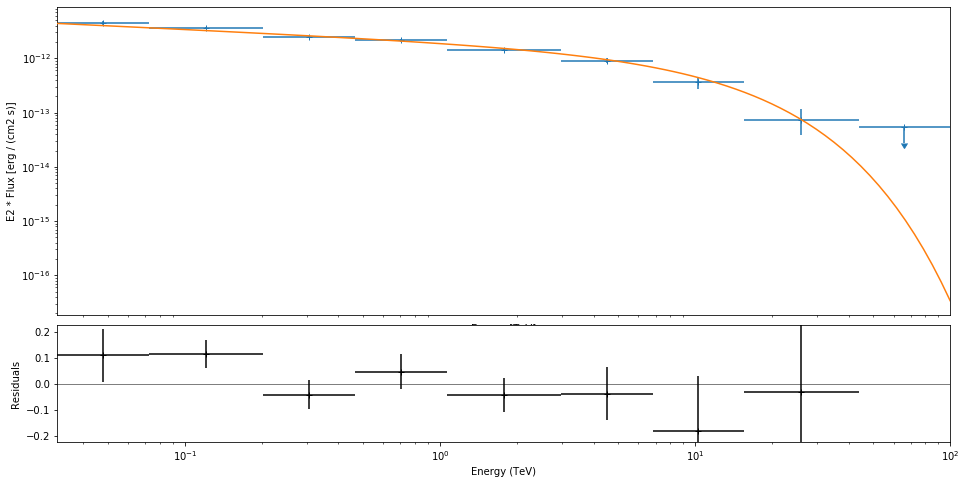

In [22]:
plt.figure(figsize=(16, 8))
flux_points_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

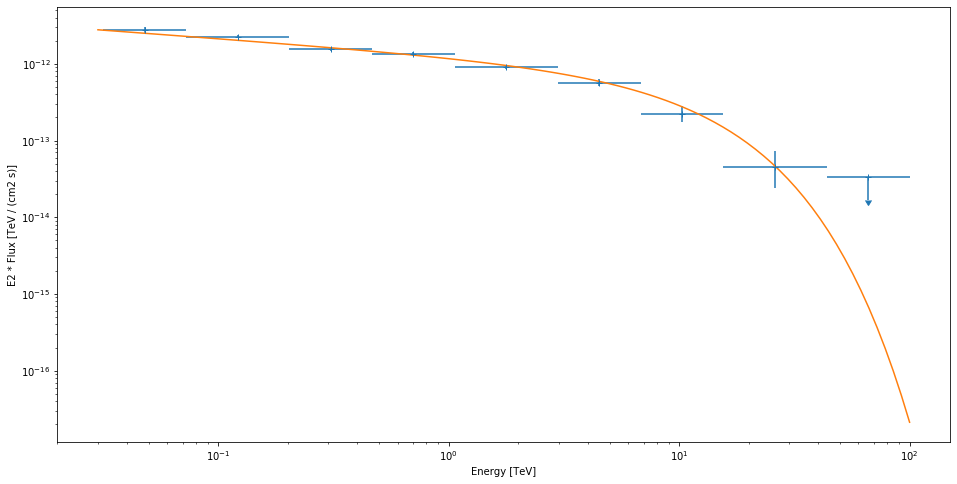

In [23]:
energy_range = [0.03, 100] * u.TeV
plt.figure(figsize=[16,8])
fpes[i].plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

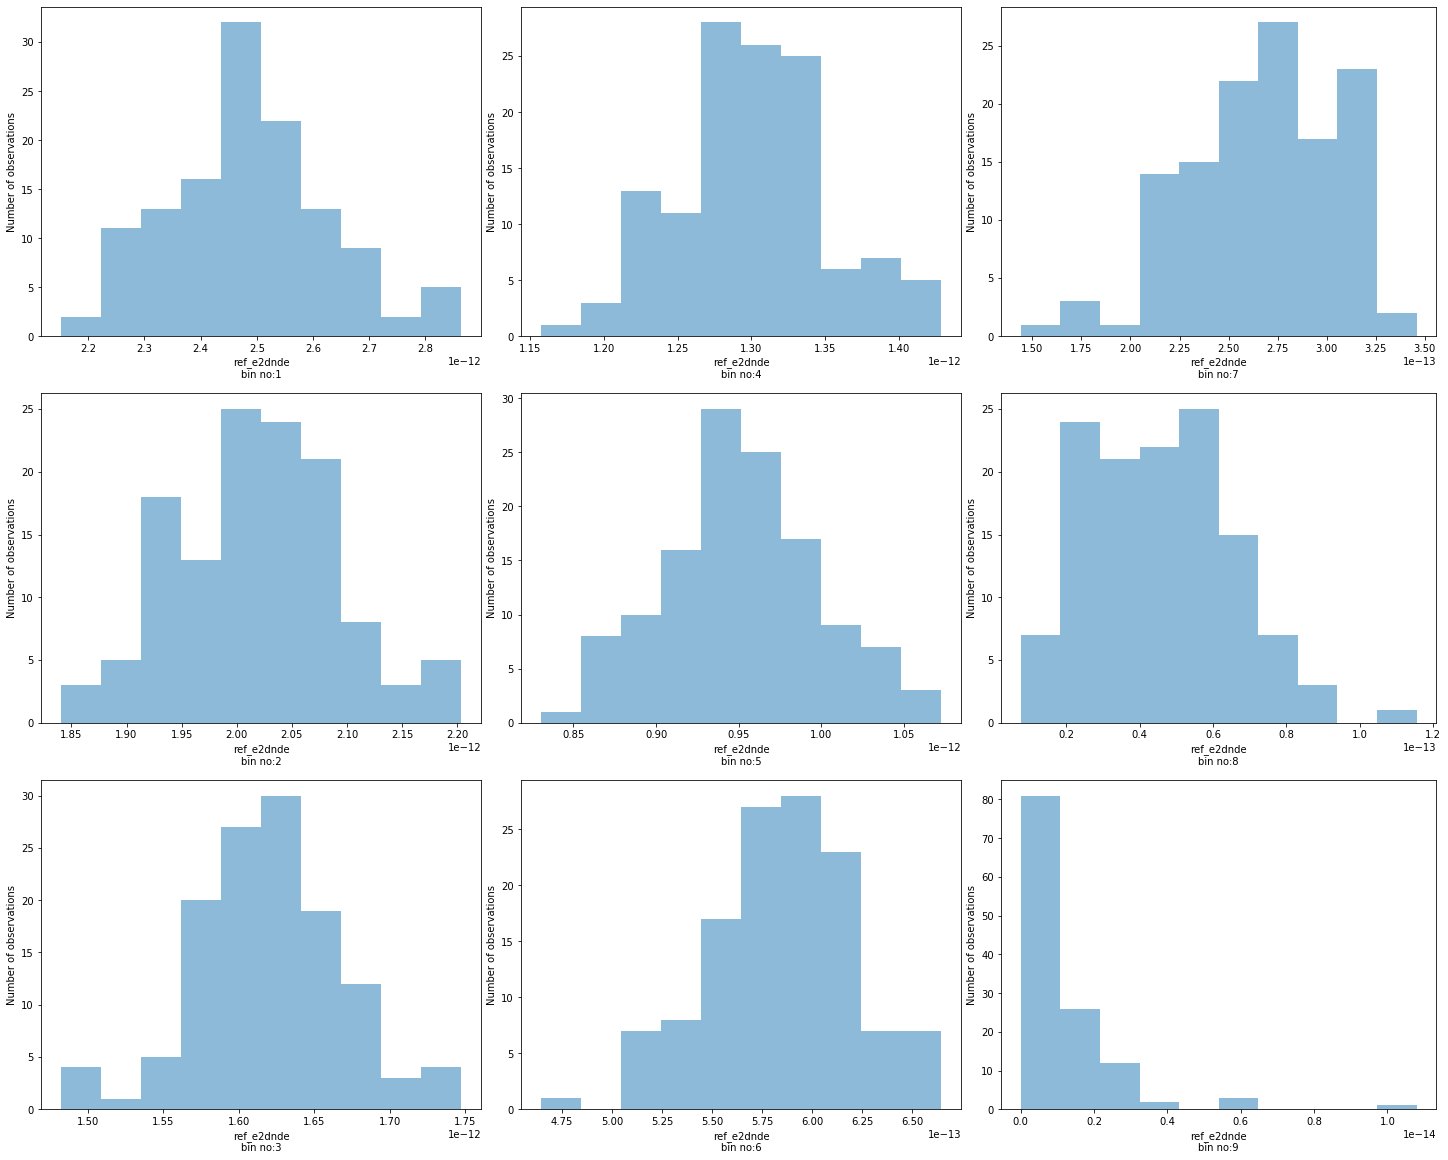

In [24]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

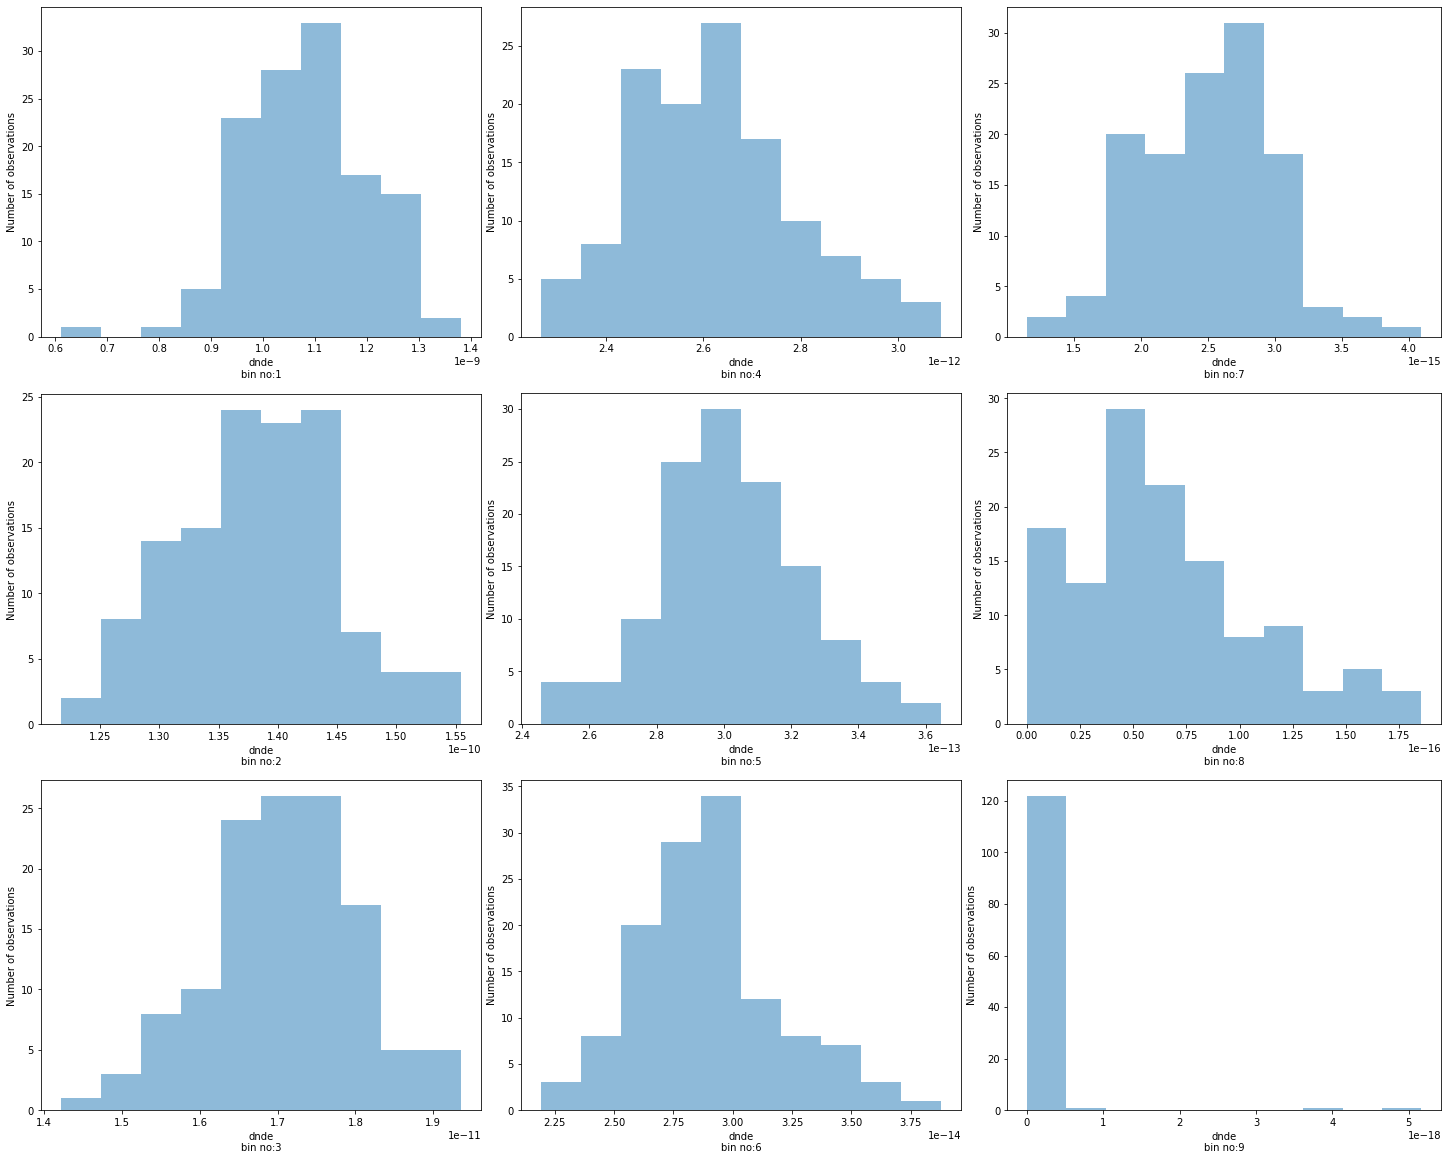

In [25]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['dnde'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['dnde'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['dnde'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

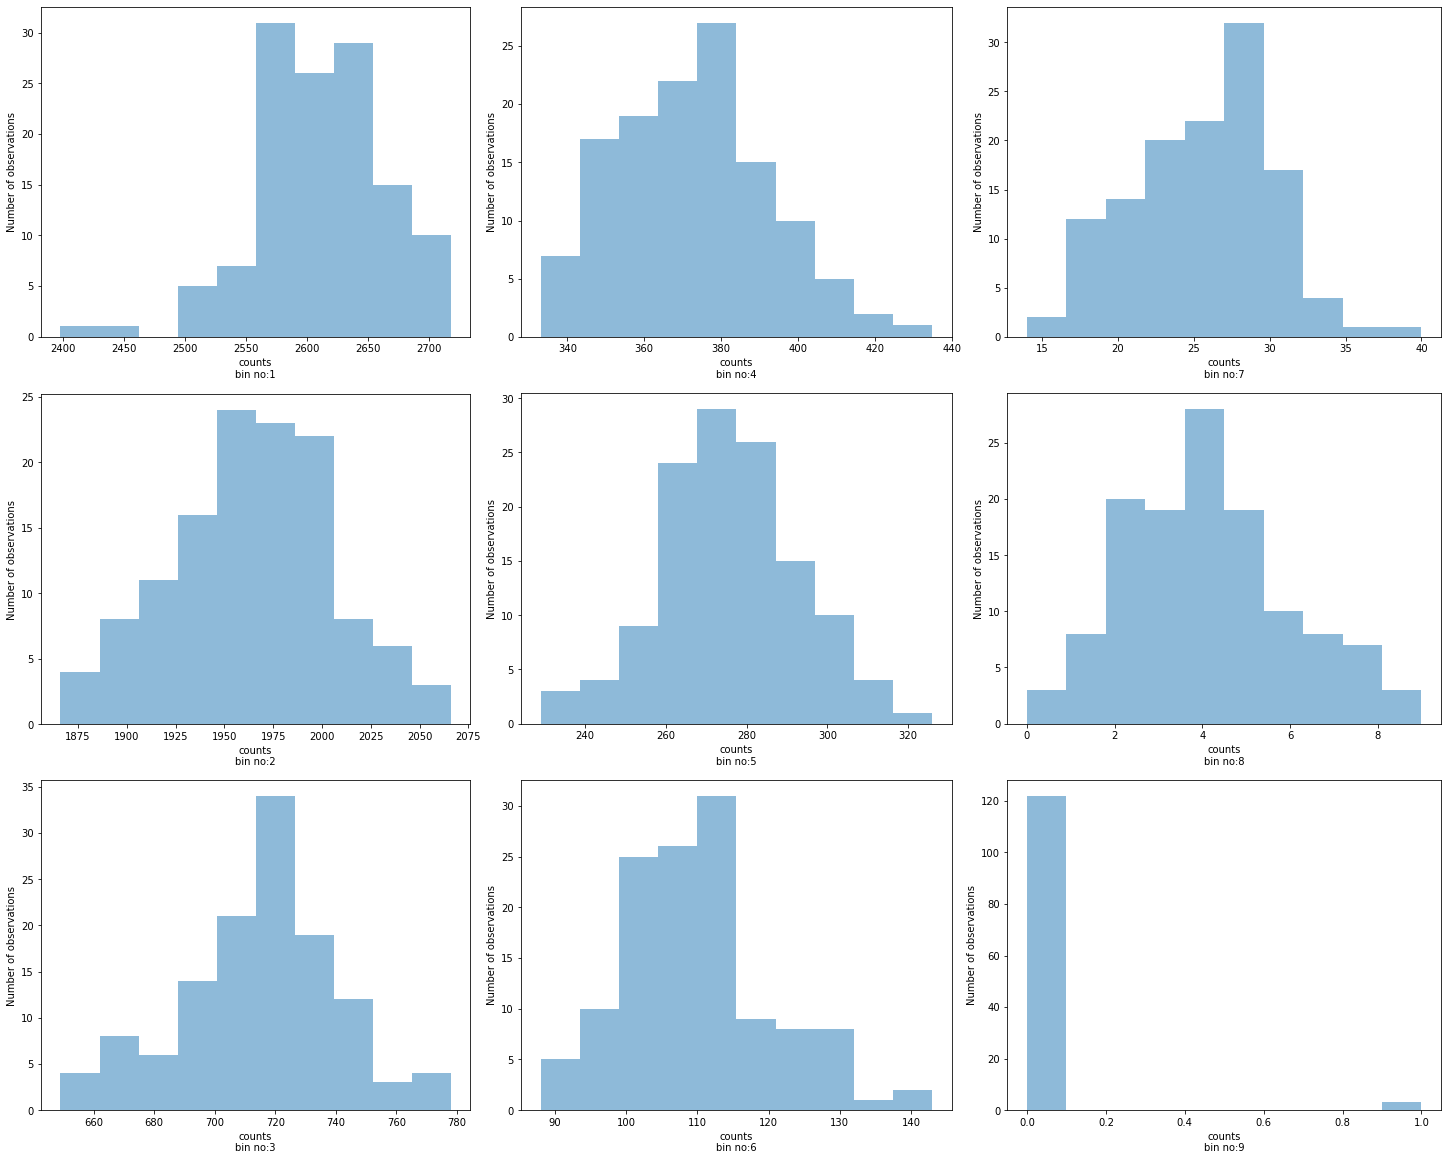

In [26]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['counts'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['counts'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['counts'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

In [27]:
x = ['e_ref','e_min','e_max','ref_dnde','ref_flux','ref_eflux','ref_e2dnde','norm','stat','norm_err','norm_errp','norm_errn','norm_ul','sqrt_ts','ts','norm_scan','stat_scan','dnde','dnde_ul','dnde_err','dnde_errp','dnde_errn']

In [28]:
flux_points_mean = fpe.run()
flux_points_mean.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.123e-09,4.633e-11,2.124e-12,2.566e-12,1.112,2.444,0.099,2681,0.100,0.099,1.313,12.019,144.449,0.200 .. 5.000,97.150 .. 1060.265,1.249e-09,1.474e-09,1.113e-10,1.119e-10,1.107e-10
0.121,0.072,0.203,1.392e-10,1.865e-11,2.116e-12,2.043e-12,0.988,2.452,0.053,1978,0.053,0.052,1.094,21.639,468.244,0.200 .. 5.000,282.399 .. 2928.010,1.375e-10,1.523e-10,7.321e-12,7.362e-12,7.279e-12
0.307,0.203,0.464,1.708e-11,4.531e-12,1.332e-12,1.610e-12,0.973,0.341,0.057,695,0.057,0.056,1.089,21.779,474.310,0.200 .. 5.000,267.979 .. 1974.671,1.661e-11,1.860e-11,9.718e-13,9.811e-13,9.625e-13
0.702,0.464,1.061,2.590e-12,1.573e-12,1.055e-12,1.275e-12,0.977,0.065,0.066,366,0.067,0.064,1.112,20.805,432.846,0.200 .. 5.000,233.036 .. 1319.995,2.529e-12,2.880e-12,1.697e-13,1.726e-13,1.670e-13
1.778,1.061,2.981,2.924e-13,5.813e-13,9.554e-13,9.248e-13,1.014,5.298,0.068,270,0.069,0.067,1.155,23.244,540.263,0.200 .. 5.000,287.273 .. 1120.075,2.965e-13,3.379e-13,1.990e-14,2.030e-14,1.950e-14
4.507,2.981,6.813,2.831e-14,1.125e-13,4.754e-13,5.749e-13,1.041,2.581,0.107,112,0.110,0.103,1.269,15.630,244.302,0.200 .. 5.000,129.399 .. 453.913,2.948e-14,3.591e-14,3.021e-15,3.123e-15,2.922e-15
10.300,6.813,15.571,2.595e-15,2.456e-14,2.306e-13,2.753e-13,1.081,2.286,0.220,28,0.235,0.206,1.579,7.790,60.681,0.200 .. 5.000,35.410 .. 108.872,2.806e-15,4.097e-15,5.708e-16,6.098e-16,5.339e-16
26.102,15.571,43.755,7.424e-17,3.028e-15,6.283e-14,5.058e-14,0.495,3.917,0.350,2,0.437,0.309,1.559,1.803,3.250,0.200 .. 5.000,4.815 .. 31.034,3.678e-17,1.157e-16,2.601e-17,3.247e-17,2.295e-17


In [29]:
for _ in x:
    y = 0
    for bin in fpes:
        y = y + bin.table[_]
    y = y/len(fpes)
    flux_points_mean.table[_] = y
    
y = 0
for bin in fpes:
    y = y + bin.table['counts']
y = y/len(fpes)
flux_points_mean.table['counts'] = y.astype(int)

In [30]:
flux_points_mean.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.088e-09,4.486e-11,2.059e-12,2.488e-12,0.994,3.300,0.101,2611,0.101,0.101,1.199,10.502,111.510,0.200 .. 5.000,72.971 .. 1083.318,1.083e-09,1.305e-09,1.096e-10,1.101e-10,1.091e-10
0.121,0.072,0.203,1.375e-10,1.838e-11,2.089e-12,2.018e-12,1.006,3.917,0.053,1964,0.054,0.053,1.114,21.789,475.725,0.200 .. 5.000,291.437 .. 2859.282,1.384e-10,1.532e-10,7.320e-12,7.356e-12,7.283e-12
0.307,0.203,0.464,1.718e-11,4.552e-12,1.340e-12,1.620e-12,0.995,2.794,0.057,714,0.058,0.057,1.112,22.038,486.842,0.200 .. 5.000,281.925 .. 1954.928,1.709e-11,1.911e-11,9.862e-13,9.958e-13,9.766e-13
0.702,0.464,1.061,2.642e-12,1.603e-12,1.076e-12,1.301e-12,0.993,2.977,0.065,372,0.066,0.064,1.127,21.480,462.629,0.200 .. 5.000,254.657 .. 1342.353,2.625e-12,2.979e-12,1.714e-13,1.742e-13,1.686e-13
1.778,1.061,2.981,3.009e-13,5.974e-13,9.819e-13,9.514e-13,1.004,3.595,0.067,275,0.068,0.066,1.143,23.319,545.259,0.200 .. 5.000,286.024 .. 1156.194,3.020e-13,3.439e-13,2.013e-14,2.057e-14,1.970e-14
4.507,2.981,6.813,2.881e-14,1.147e-13,4.837e-13,5.851e-13,1.008,2.956,0.104,109,0.107,0.101,1.229,15.542,242.873,0.200 .. 5.000,127.178 .. 475.114,2.901e-14,3.537e-14,2.985e-15,3.084e-15,2.889e-15
10.300,6.813,15.571,2.534e-15,2.415e-14,2.260e-13,2.688e-13,0.992,3.196,0.215,25,0.230,0.201,1.481,7.370,55.421,0.200 .. 5.000,31.551 .. 114.600,2.514e-15,3.738e-15,5.395e-16,5.759e-16,5.047e-16
26.102,15.571,43.755,6.753e-17,2.808e-15,5.810e-14,4.601e-14,0.957,3.259,0.538,4,0.656,0.445,2.500,2.642,8.521,0.200 .. 5.000,8.125 .. 21.442,6.623e-17,1.604e-16,3.433e-17,4.063e-17,2.885e-17


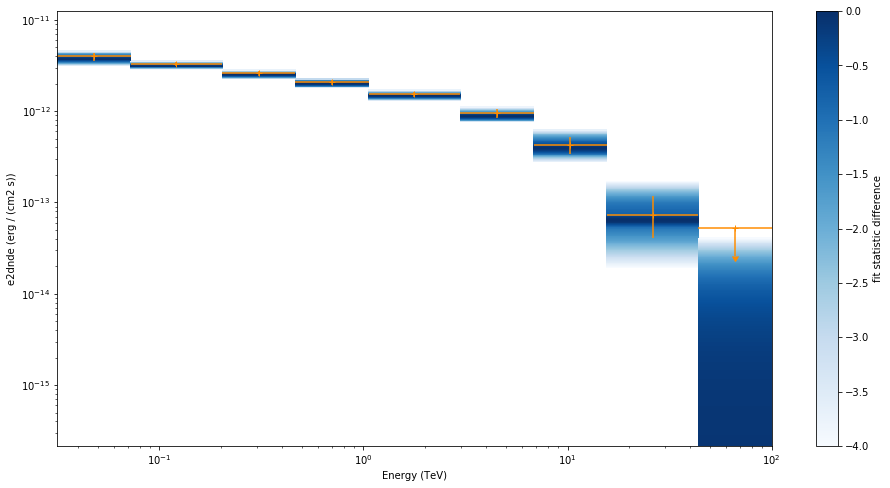

In [31]:
plt.figure(figsize=(16, 8))
flux_points_mean.table["is_ul"] = flux_points_mean.table["ts"] < 4
ax = flux_points_mean.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points_mean.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [32]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points_mean, models=model_best_joints[124]
)

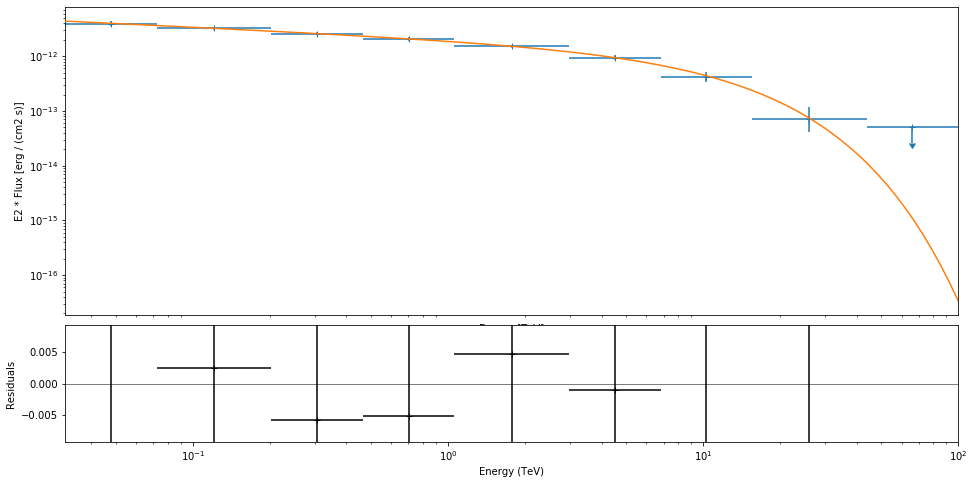

In [33]:
plt.figure(figsize=(16, 8))
flux_points_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

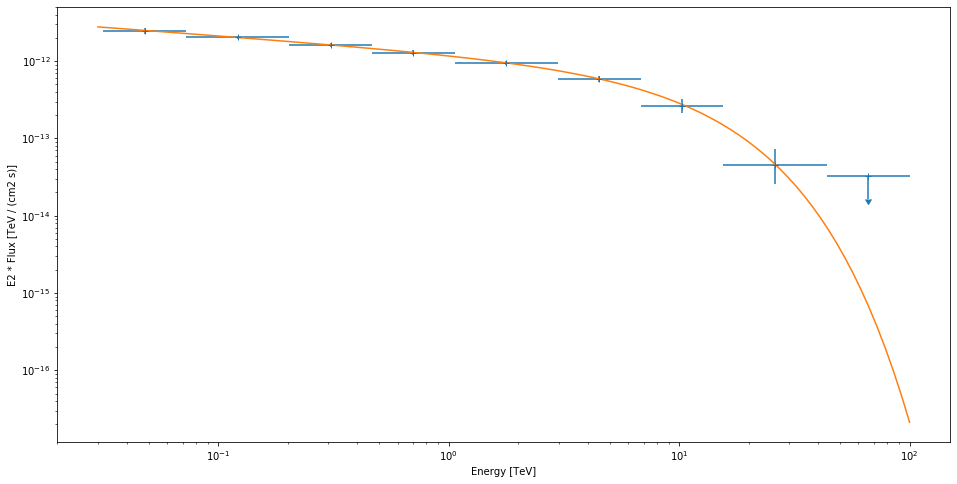

In [34]:
plt.figure(figsize=[16,8])
flux_points_mean.plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

In [39]:
fp = FluxPointsEstimator(datasets=datasets, e_edges=e_edges)
flu_pois = fp.run()

In [40]:
flu_pois.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [125],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.253e-09,5.184e-11,2.372e-12,2.863e-12,0.870,551.242,0.008,2670 .. 2681,0.008,0.008,0.886,117.474,13800.067,0.200 .. 5.000,8502.169 .. 178733.997,1.090e-09,1.110e-09,9.858e-12,9.839e-12,9.878e-12
0.121,0.072,0.203,1.501e-10,2.019e-11,2.284e-12,2.204e-12,0.922,613.843,0.004,2045 .. 1978,0.004,0.004,0.931,243.601,59341.360,0.200 .. 5.000,34687.243 .. 422245.089,1.384e-10,1.397e-10,6.542e-13,6.546e-13,6.539e-13
0.307,0.203,0.464,1.779e-11,4.733e-12,1.389e-12,1.677e-12,0.960,471.622,0.005,704 .. 695,0.005,0.005,0.970,246.441,60732.927,0.200 .. 5.000,34514.978 .. 260425.991,1.709e-11,1.726e-11,8.814e-14,8.820e-14,8.807e-14
0.702,0.464,1.061,2.614e-12,1.592e-12,1.065e-12,1.287e-12,1.004,503.426,0.006,394 .. 366,0.006,0.006,1.015,240.203,57697.368,0.200 .. 5.000,32097.782 .. 165102.924,2.624e-12,2.654e-12,1.532e-14,1.534e-14,1.529e-14
1.778,1.061,2.981,2.843e-13,5.678e-13,9.299e-13,8.989e-13,1.062,599.797,0.006,261 .. 270,0.006,0.006,1.074,260.781,68006.941,0.200 .. 5.000,37232.479 .. 131439.353,3.018e-13,3.054e-13,1.799e-15,1.803e-15,1.795e-15
4.507,2.981,6.813,2.634e-14,1.052e-13,4.431e-13,5.350e-13,1.099,494.683,0.010,106 .. 112,0.010,0.010,1.119,173.879,30233.935,0.200 .. 5.000,16894.267 .. 51187.506,2.894e-14,2.948e-14,2.666e-16,2.679e-16,2.653e-16
10.300,6.813,15.571,2.295e-15,2.189e-14,2.048e-13,2.435e-13,1.095,506.054,0.021,23 .. 28,0.021,0.021,1.138,82.590,6821.126,0.200 .. 5.000,4226.208 .. 12211.054,2.514e-15,2.612e-15,4.845e-17,4.877e-17,4.813e-17
26.102,15.571,43.755,6.001e-17,2.519e-15,5.193e-14,4.088e-14,1.098,558.563,0.055,4 .. 2,0.056,0.054,1.211,30.231,913.934,0.200 .. 5.000,1083.677 .. 2353.557,6.586e-17,7.265e-17,3.290e-18,3.343e-18,3.239e-18


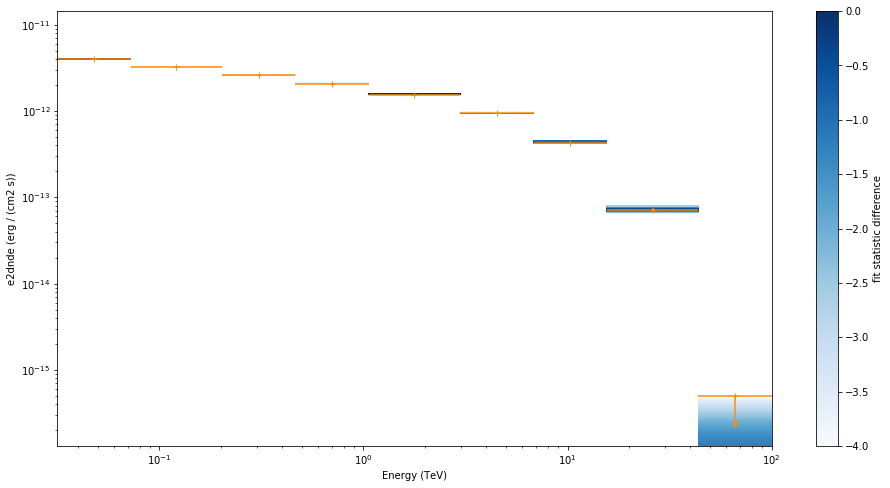

In [41]:
plt.figure(figsize=(16, 8))
flu_pois.table["is_ul"] = flu_pois.table["ts"] < 4
ax = flu_pois.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flu_pois.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [42]:
flu_pois_dataset = FluxPointsDataset(
    data=flu_pois, models=model_best_joints[124]
)

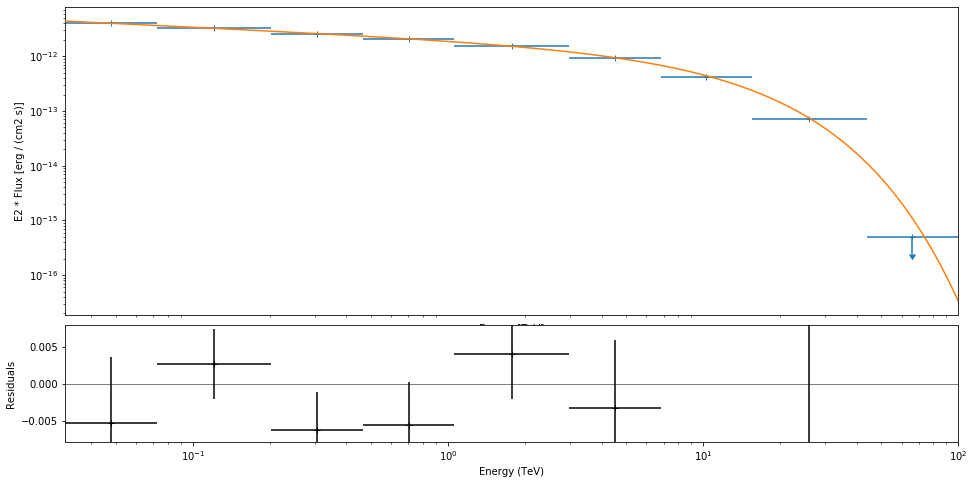

In [43]:
plt.figure(figsize=(16, 8))
flu_pois_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

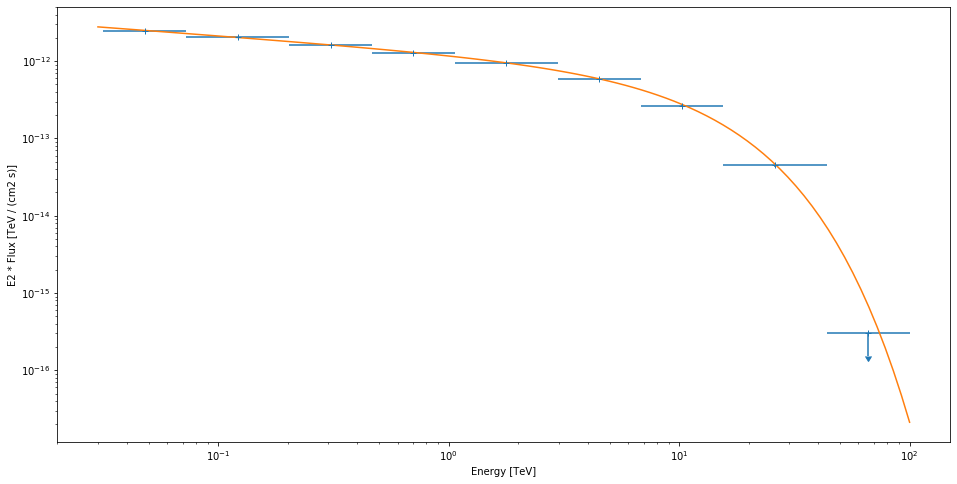

In [44]:
plt.figure(figsize=[16,8])
flu_pois.plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

In [36]:
datasets[0].edisp.to_table()

ENERG_LO,ENERG_HI,N_GRP,F_CHAN,N_CHAN,MATRIX
TeV,TeV,,,,
float64,float64,int16,object,object,object
0.0316227766016838,0.0329297125509715,1,[0],[4],[0.37030434 0.12980831 0.03220612 0.00911744]
0.0329297125509715,0.034290662782339984,1,[0],[5],[0.44966429 0.12873106 0.04719896 0.0203101 0.02035599]
0.034290662782339984,0.035707859649004636,1,[0],[4],[0.28760593 0.26002035 0.14893997 0.01976812]
0.035707859649004636,0.037183627764980874,1,[0],[4],[0.43400932 0.33356029 0.04667589 0.01710435]
0.037183627764980874,0.03872038781812555,1,[0],[5],[0.38084856 0.29239337 0.11519399 0.04174333 0.010126 ]
0.03872038781812555,0.04032066054076736,1,[0],[5],[0.20218768 0.41744356 0.20919646 0.02878125 0.00729188]
0.04032066054076736,0.0419870708444391,1,[0],[5],[0.24224841 0.48474054 0.10097427 0.02321799 0.02347255]
0.0419870708444391,0.043722352125494135,1,[0],[5],[0.20860388 0.36164042 0.23668035 0.13087963 0.0284858 ]


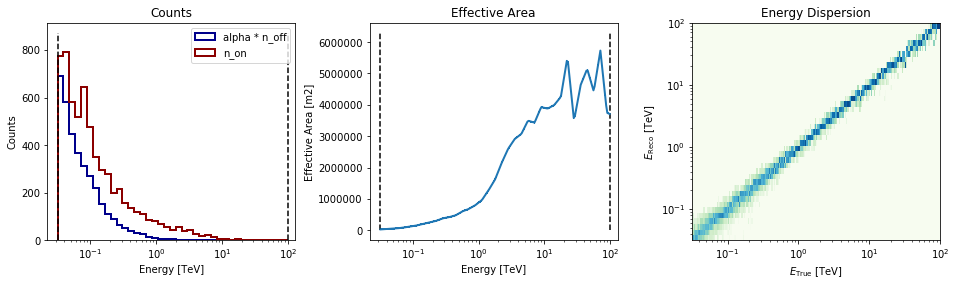

In [37]:
datasets[0].peek()

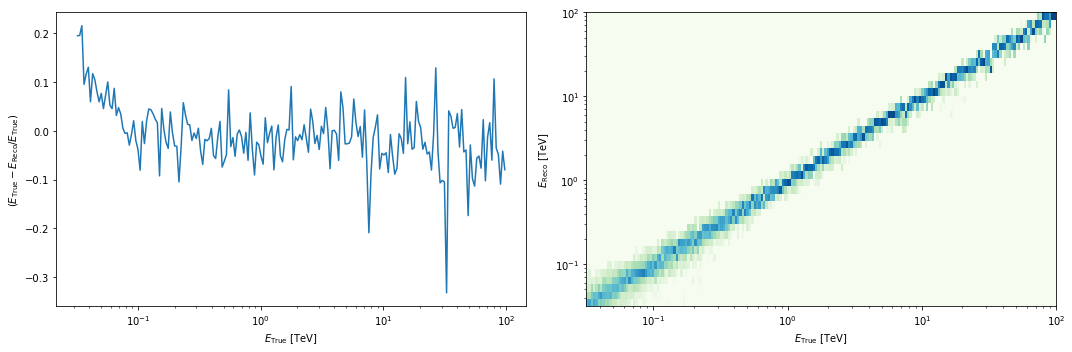

In [38]:
datasets[0].edisp.peek()